# We create necessary folders and .py files

In [1]:
import os

os.makedirs("utils", exist_ok=True)
os.makedirs("finbert_local", exist_ok=True)

In [2]:
%%writefile utils/__init__.py

UsageError: %%writefile is a cell magic, but the cell body is empty.


## Class for scrapping ecb press release list

In [3]:
%%writefile utils/ecb_scraper.py
import hashlib
import os
import re
import time
import pickle
import random
import asyncio
import aiohttp
import pandas as pd
import requests
from aiofiles import open as aio_open
from aiohttp import ClientError
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.common.exceptions import WebDriverException
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
from urllib.parse import urljoin


class ECBScraper:
    """
    ECB Press Release Scraper with verbosity control
    - verbose=0: no printing
    - verbose=1: basic progress
    - verbose=2: full printing (success/failure for each article)
    """

    BASE_URL = "https://www.ecb.europa.eu"
    START_URL = (
        "https://www.ecb.europa.eu/press/pubbydate/html/index.en.html?"
        "name_of_publication=Press%20release"
    )

    def __init__(self, pickle_path="ecb_press_releases_df.pkl",
                 scroll_pause_time=0.1, scroll_increment=50,
                 max_scroll_attempts=None, initial_wait=10, verbose=1):
        self.pickle_path = pickle_path
        self.scroll_pause_time = scroll_pause_time
        self.scroll_increment = scroll_increment
        self.max_scroll_attempts = max_scroll_attempts
        self.initial_wait = initial_wait
        self.verbose = verbose
        self.df = pd.DataFrame(columns=["Date", "Title", "URL"])
        self.existing_urls = set()
        self._load_data()

    # ------------------ Logging helpers ------------------
    def _log(self, msg, level=1):
        if self.verbose >= level:
            print(msg)

    def _log_progress(self, current, total):
        if self.verbose >= 1:
            print(f"📄 Scraped {current}/{total} articles")

    # ------------------ Pickle management -----------------
    def _load_data(self):
        if os.path.exists(self.pickle_path):
            try:
                self.df = pd.read_pickle(self.pickle_path)
                if not isinstance(self.df, pd.DataFrame):
                    raise ValueError("Pickle content invalid.")
                self.existing_urls = set(self.df["URL"].unique())
                self._log(f"✅ Loaded {len(self.df)} existing articles.", level=1)
            except Exception as e:
                self._log(f"⚠️ Error loading pickle: {e}. Starting fresh.", level=1)
                self.df = pd.DataFrame(columns=["Date", "Title", "URL"])
                self.existing_urls = set()
        else:
            self._log(f"ℹ️ No pickle found, starting fresh.", level=1)
            self.df = pd.DataFrame(columns=["Date", "Title", "URL"])
            self.existing_urls = set()

    def _save_data(self):
        if not self.df.empty:
            self.df.to_pickle(self.pickle_path)
            self._log(f"💾 Saved {len(self.df)} articles → {self.pickle_path}", level=1)

    # ------------------ Scraping --------------------------
    def _setup_driver(self):
        try:
            options = webdriver.ChromeOptions()
            options.add_argument("--headless")
            options.add_argument("--disable-gpu")
            options.add_argument("--no-sandbox")
            service = ChromeService(ChromeDriverManager().install())
            return webdriver.Chrome(service=service, options=options)
        except WebDriverException as e:
            self._log(f"❌ WebDriver setup error: {e}", level=1)
            return None

    def _scroll_page(self, driver):
        self._log("📜 Scrolling page...", level=1)
        attempt = 0
        while True:
            last_scroll_position = driver.execute_script("return window.pageYOffset;")
            driver.execute_script(f"window.scrollBy(0, {self.scroll_increment});")
            time.sleep(self.scroll_pause_time)
            new_scroll_position = driver.execute_script("return window.pageYOffset;")
            if new_scroll_position == last_scroll_position:
                self._log("✅ Reached page bottom.", level=1)
                break
            attempt += 1
            if self.max_scroll_attempts and attempt >= self.max_scroll_attempts:
                self._log("⚠️ Max scroll attempts reached.", level=1)
                break

    def _extract_articles(self, html_content):
        soup = BeautifulSoup(html_content, "html.parser")
        main_content = soup.find("div", id="ecb-content-col") or soup.find("main")
        if not main_content:
            self._log("⚠️ Could not find main content section.", level=1)
            return []

        articles = []
        current_date = None
        sort_wrapper = main_content.find("div", class_="sort-wrapper")
        if not sort_wrapper:
            self._log("⚠️ No sort-wrapper found.", level=1)
            return []

        dl = sort_wrapper.find("dl", recursive=False)
        if not dl:
            self._log("⚠️ No <dl> in sort-wrapper.", level=1)
            return []

        for tag in dl.find_all(["dt", "dd"], recursive=False):
            if tag.name == "dt":
                current_date = tag.get_text(strip=True)
            elif tag.name == "dd" and current_date:
                cat_div = tag.find("div", class_="category")
                title_div = tag.find("div", class_="title")
                if not (cat_div and title_div):
                    continue
                if cat_div.get_text(strip=True) != "Press release":
                    continue
                link_tag = title_div.find("a", href=True)
                if not link_tag:
                    continue
                url = urljoin(self.BASE_URL, link_tag["href"])
                if "/press/pr/" not in url:
                    continue
                title = link_tag.get_text(strip=True)
                articles.append({"Date": current_date, "Title": title, "URL": url})
        return articles

    def scrape_and_update(self):
        driver = self._setup_driver()
        if not driver:
            return

        try:
            self._log(f"🌐 Navigating to {self.START_URL}", level=1)
            driver.get(self.START_URL)
            time.sleep(self.initial_wait)
            self._scroll_page(driver)
            html = driver.page_source
        except Exception as e:
            self._log(f"❌ Error scraping: {e}", level=1)
            return
        finally:
            driver.quit()

        articles = self._extract_articles(html)
        self._log(f"📰 Found {len(articles)} articles total.", level=1)
        new_articles = [a for a in articles if a["URL"] not in self.existing_urls]

        if not new_articles:
            self._log("ℹ️ No new articles found.", level=1)
            return

        new_df = pd.DataFrame(new_articles)
        self.df = pd.concat([new_df, self.df]).drop_duplicates("URL", keep="first").reset_index(drop=True)
        self.existing_urls.update(new_df["URL"])
        self._save_data()
        self._log(f"✅ Added {len(new_articles)} new articles.", level=1)

    # ------------------ Async fetching -------------------
    async def _fetch_article(self, session, url, retries=3):
        """
        Fetch the text content of one article from its URL asynchronously.
        Preserves the order of <h1>, <h3>, <p>, <ul>/<ol> and relevant <div> across <main>,
        while ignoring full divs like 'address-box -top-arrow' and 'see-also-boxes'.
        Avoids duplicated text.
        """
        for attempt in range(retries):
            try:
                async with session.get(url, timeout=20) as resp:
                    if resp.status != 200:
                        raise aiohttp.ClientError(f"Status {resp.status}")
                    html = await resp.text()
                    soup = BeautifulSoup(html, "html.parser")

                    main = soup.find("main")
                    if not main:
                        return ""

                    # Remove unwanted sections
                    for div in main.find_all("div", class_=["address-box", "-top-arrow", "see-also-boxes"]):
                        div.decompose()

                    content = []
                    seen_text = set()

                    # Add main headline <h1> first
                    h1 = main.find("h1", class_="ecb-pressContentTitle")
                    if h1:
                        text = h1.get_text(strip=True)
                        if text:
                            content.append(text)
                            seen_text.add(text)

                    # Traverse all sections individually
                    for section in main.find_all("div", class_="section"):
                        for element in section.find_all(["h3", "p", "ul", "ol"], recursive=True):
                            if element.name in ["h3", "p"]:
                                text = element.get_text(strip=True)
                                if text and text not in seen_text:
                                    content.append(text)
                                    seen_text.add(text)
                            elif element.name in ["ul", "ol"]:
                                for li in element.find_all("li"):
                                    li_text = li.get_text(strip=True)
                                    if li_text and li_text not in seen_text:
                                        content.append(f"• {li_text}")
                                        seen_text.add(li_text)

                    return "\n\n".join(content).strip()

            except Exception as e:
                wait = 2 ** attempt + random.uniform(0, 0.5)
                self._log(f"⚠️ Error fetching {url} ({e}), retrying in {wait:.1f}s...", level=2)
                await asyncio.sleep(wait)

        self._log(f"❌ Failed to fetch {url} after {retries} retries.", level=2)
        return ""

    async def _save_article(self, semaphore, session, row, folder):
        async with semaphore:
            title, url = row.Title, row.URL
            date = str(row.Date)
            safe_title = re.sub(r"[^a-zA-Z0-9 _-]", "_", title)

            # Add formatted date string (year_monthname_day)
            parts = date.split()
            if len(parts) >= 3:
                day, month, year = parts[0], parts[1], parts[2]
                date_str = f"{year}_{month}_{day}"
            else:
                date_str = re.sub(r"[^0-9]", "", date)[:8] or "unknown"

            if len(safe_title) > 230:
                safe_title = safe_title[:230]
            safe_title = f"{safe_title}_{date_str}"

            file_path = os.path.join(folder, f"{safe_title}.txt")

            if os.path.exists(file_path):
                if self.verbose == 2:
                    self._log(f"⏩ Skipping '{title}' (already saved)", level=2)
                return

            try:
                text = await self._fetch_article(session, url)
                if not text or not text.strip():
                    if self.verbose >= 2:
                        self._log(f"⚠️ Skipping '{title}' (fetch failed or empty content)", level=2)
                    return

                async with aio_open(file_path, "w", encoding="utf-8") as f:
                    await f.write(text)

                if self.verbose == 2:
                    self._log(f"✅ Saved '{title}'", level=2)

            except Exception as e:
                if self.verbose >= 2:
                    self._log(f"⚠️ Fetch failed for '{title}' ({e}), no file created.", level=2)


    async def scrape_all_texts_to_files_async(self, folder="ecb_press_release", concurrency=6):
        """
        Scrape all articles in self.df and save them as text files asynchronously.
        The final count of saved articles is computed by counting files in the folder.
        """
        os.makedirs(folder, exist_ok=True)
        n = len(self.df)

        headers = {
            "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                        "AppleWebKit/537.36 (KHTML, like Gecko) "
                        "Chrome/118.0 Safari/537.36"
        }

        semaphore = asyncio.Semaphore(concurrency)
        connector = aiohttp.TCPConnector(limit_per_host=concurrency, force_close=True)

        async with aiohttp.ClientSession(headers=headers, connector=connector) as session:
            tasks = [self._save_article(semaphore, session, row, folder)
                    for row in self.df.itertuples(index=False)]
            await asyncio.gather(*tasks)

        # Count saved files in folder
        saved_count = len([f for f in os.listdir(folder) if f.endswith(".txt")])
        self._log(f"📄 Scraped {saved_count}/{n} articles successfully", level=1)
        self._log(f"🎉 All texts attempted to save in '{folder}/'", level=1)
        
    # ------------------ Async fetching (summaries only) -------------------
    async def _fetch_article_summary(self, session, url, retries=3):
        """
        Fetch only the summary part of an ECB press release.
        - Normally takes the first <ul> inside <main>.
        - If the first <ul> contains an <li> with text including 'PRESS RELEASE',
          then takes the second <ul> instead.
        - Some articles does not have summary at the begining si it's finally not suitable for our project.
        """
        for attempt in range(retries):
            try:
                async with session.get(url, timeout=20) as resp:
                    if resp.status != 200:
                        raise aiohttp.ClientError(f"Status {resp.status}")
                    html = await resp.text()
                    soup = BeautifulSoup(html, "html.parser")

                    main = soup.find("main")
                    if not main:
                        return ""

                    # Remove irrelevant divs
                    for div in main.find_all("div", class_=["address-box", "-top-arrow", "see-also-boxes"]):
                        div.decompose()

                    # Find all <ul> inside <main>
                    uls = [
                        ul for ul in main.find_all("ul", recursive=True)
                        if not any(x in (ul.get("class") or []) for x in ["social", "breadcrumb"])
                    ]
                    if not uls:
                        return ""

                    chosen_ul = uls[0]

                    # Check if the first UL has an LI containing "PRESS RELEASE"
                    first_ul_texts = [li.get_text(strip=True).upper() for li in uls[0].find_all("li")]
                    if any("PRESS RELEASE" in t for t in first_ul_texts) and len(uls) > 1:
                        chosen_ul = uls[1]

                    summary_points = []
                    seen_text = set()

                    # Only take direct li children (not nested)
                    for li in chosen_ul.find_all("li", recursive=False):
                        li_text = li.get_text(strip=True)
                        if li_text and li_text not in seen_text:
                            summary_points.append(f"• {li_text}")
                            seen_text.add(li_text)

                    return "\n".join(summary_points).strip()

            except Exception as e:
                wait = 2 ** attempt + random.uniform(0, 0.5)
                self._log(f"⚠️ Error fetching summary {url} ({e}), retrying in {wait:.1f}s...", level=2)
                await asyncio.sleep(wait)

        self._log(f"❌ Failed to fetch summary {url} after {retries} retries.", level=2)
        return ""

    async def _save_summary(self, semaphore, session, row, folder):
        async with semaphore:
            title, url = row.Title, row.URL
            date = str(row.Date)
            safe_title = re.sub(r"[^a-zA-Z0-9 _-]", "_", title)

            # Add formatted date string (year_monthname_day)
            parts = date.split()
            if len(parts) >= 3:
                day, month, year = parts[0], parts[1], parts[2]
                date_str = f"{year}_{month}_{day}"
            else:
                date_str = re.sub(r"[^0-9]", "", date)[:8] or "unknown"

            if len(safe_title) > 230:
                safe_title = safe_title[:230]
            safe_title = f"{safe_title}_{date_str}"

            file_path = os.path.join(folder, f"{safe_title}.txt")

            if os.path.exists(file_path):
                if self.verbose == 2:
                    self._log(f"⏩ Skipping summary '{title}' (already saved)", level=2)
                return

            try:
                summary = await self._fetch_article_summary(session, url)
                if not summary or not summary.strip():
                    if self.verbose >= 2:
                        self._log(f"⚠️ Skipping summary '{title}' (fetch failed or empty content)", level=2)
                    return

                async with aio_open(file_path, "w", encoding="utf-8") as f:
                    await f.write(summary)

                if self.verbose == 2:
                    self._log(f"✅ Saved summary '{title}'", level=2)

            except Exception as e:
                if self.verbose >= 2:
                    self._log(f"⚠️ Fetch failed for summary '{title}' ({e}), no file created.", level=2)

    async def scrape_all_summaries_to_files_async(self, folder="ecb_press_release_summary", concurrency=6):
        """
        Scrape only the summaries (first <ul> list inside main) of all articles in self.df
        and save them as text files asynchronously.
        """
        os.makedirs(folder, exist_ok=True)
        n = len(self.df)

        headers = {
            "User-Agent": (
                "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                "AppleWebKit/537.36 (KHTML, like Gecko) "
                "Chrome/118.0 Safari/537.36"
            )
        }

        semaphore = asyncio.Semaphore(concurrency)
        connector = aiohttp.TCPConnector(limit_per_host=concurrency, force_close=True)

        async with aiohttp.ClientSession(headers=headers, connector=connector) as session:
            tasks = [self._save_summary(semaphore, session, row, folder)
                     for row in self.df.itertuples(index=False)]
            await asyncio.gather(*tasks)

        saved_count = len([f for f in os.listdir(folder) if f.endswith(".txt")])
        self._log(f"📄 Saved {saved_count}/{n} summaries successfully", level=1)
        self._log(f"🎉 All summaries attempted to save in '{folder}/'", level=1)


Overwriting utils/ecb_scraper.py


## Class for loading finbert model

In [4]:
%%writefile utils/finbert_loader.py
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, logging
import os

class FinBERTLoader:
    """
    Class to manage loading and saving of FinBERT model and tokenizer.
    Handles automatic downloading or loading from local storage.
    """

    def __init__(self, model_name="ProsusAI/finbert", local_dir="./finbert_local"):
        """
        Initialize the FinBERT loader.

        Args:
            model_name (str): HuggingFace model name
            local_dir (str): Directory to save/load the model locally
        """
        self.model_name = model_name
        self.local_dir = local_dir
        self.model = None
        self.tokenizer = None

    def load(self):
        """
        Load the model and tokenizer, either from local storage if available,
        or download from HuggingFace if not.
        """
        if self._is_model_cached():
            print("Loading FinBERT from local storage...")
            self.model = AutoModelForSequenceClassification.from_pretrained(self.local_dir)
            self.tokenizer = AutoTokenizer.from_pretrained(self.local_dir)
        else:
            print("Downloading FinBERT from HuggingFace...")
            logging.set_verbosity_info()
            self.model = AutoModelForSequenceClassification.from_pretrained(self.model_name)
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
            self._save_local()

        print("FinBERT loaded successfully!")
        return self

    def _is_model_cached(self):
        """Check if model files exist in local directory."""
        return os.path.exists(self.local_dir) and os.path.exists(os.path.join(self.local_dir, "config.json"))

    def _save_local(self):
        """Save model and tokenizer to local directory."""
        print("Saving model locally for future use...")
        os.makedirs(self.local_dir, exist_ok=True)
        self.model.save_pretrained(self.local_dir)
        self.tokenizer.save_pretrained(self.local_dir)

    def _chunk_text(self, tokens, max_length=512):
        """Helper to split tokens into chunks of max_length."""
        for i in range(0, len(tokens), max_length):
            chunk = tokens[i:i + max_length]
            yield chunk

    def _from_text_to_tokens(self, text):
        """
        Tokenize the input text using the FinBERT tokenizer.
        For texts longer than 512 tokens, splits into chunks.
        Returns list of tokenized inputs suitable for the model.
        """
        if not self.tokenizer:
            raise RuntimeError("Tokenizer not loaded. Call load() first.")

        # First encode without special tokens to get raw tokens
        tokens = self.tokenizer.encode(text, add_special_tokens=False)

        # If text is short enough, process normally
        if len(tokens) <= 512:
            return [self.tokenizer(text, return_tensors="pt", truncation=True, 
                                 max_length=512, padding=True)]

        # For long texts, split into chunks
        all_inputs = []
        for chunk in self._chunk_text(tokens):
            # Decode chunk back to text and re-encode properly with special tokens
            chunk_text = self.tokenizer.decode(chunk)
            inputs = self.tokenizer(chunk_text, return_tensors="pt", 
                                  truncation=True, max_length=512, padding=True)
            all_inputs.append(inputs)

        return all_inputs

    def text_to_logits(self, text):
        """
        Analyze the sentiment of a given text using FinBERT.
        For long texts, aggregates chunk predictions using mean or max.

        Args:
            text (str): Text to analyze
            aggregate (str): Aggregation method for long texts ('mean' or 'max')

        Returns:
            torch.Tensor: Logits for positive/negative/neutral sentiment
        """
        if not self.model or not self.tokenizer:
            raise RuntimeError("Model not loaded. Call load() first.")

        inputs_list = self._from_text_to_tokens(text)
        all_logits = []

        with torch.no_grad():
            for inputs in inputs_list:
                outputs = self.model(**inputs)
                all_logits.append(outputs.logits)

            # Stack all logits tensors
            if len(all_logits) == 1:
                return all_logits[0]

            stacked_logits = torch.cat(all_logits, dim=0)


            return torch.mean(stacked_logits, dim=0, keepdim=True)


Overwriting utils/finbert_loader.py


# Required import

In [40]:
import re
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

from utils.ecb_scraper import ECBScraper

# Ad hoc functions

In [6]:
def make_safe_title(row):
    title = str(row['Title'])
    date = str(row.get('Date', 'unknown'))
    safe_title = re.sub(r"[^a-zA-Z0-9 _-]", "_", title)
    
    # Extract year, month (in letters), and day if possible
    parts = date.split()
    if len(parts) >= 3:
        day, month, year = parts[0], parts[1], parts[2]
        date_str = f"{year}_{month}_{day}"
    else:
        date_str = re.sub(r"[^0-9]", "", date)[:8] or "unknown"
    
    if len(safe_title) > 230:
        safe_title = safe_title[:230]
    safe_title = f"{safe_title}_{date_str}"
    return safe_title

# We scrapp all ecb press release adress and download each press release in .txt file

In [7]:
scraper = ECBScraper(pickle_path="ecb_press_releases_link_df.pkl", verbose=1)

if scraper.df.empty:
    scraper.scrape_and_update()

await scraper.scrape_all_texts_to_files_async(concurrency=10)
# await scraper.scrape_all_summaries_to_files_async(concurrency=10)

✅ Loaded 2142 existing articles.
📄 Scraped 2141/2142 articles successfully
🎉 All texts attempted to save in 'ecb_press_release/'


# Finbert downloading

In [8]:
from utils.finbert_loader import FinBERTLoader
import torch.nn.functional as F

finbert = FinBERTLoader().load()

# Exemple
text = "ECB reports strong economic growth in the eurozone"
result = finbert.text_to_logits(text)
probs = F.softmax(result, dim=-1)
print("test sentence : ECB reports strong economic growth in the eurozone")
print(f"Sentiment Analysis Result: {probs}")

Loading FinBERT from local storage...
FinBERT loaded successfully!
test sentence : ECB reports strong economic growth in the eurozone
Sentiment Analysis Result: tensor([[0.9565, 0.0170, 0.0265]])


In [9]:
import os
import re
from pathlib import Path

outdir = Path(r"d:\Documents\3A\Projet ML for trading")
outdir.mkdir(parents=True, exist_ok=True)
pickle_path = outdir / "df.pkl"

# Vérifier si le fichier existe déjà
if not pickle_path.exists():
    folder = "ecb_press_release"
    finbert = FinBERTLoader().load()

    def get_text_from_title(title):
        safe_title = re.sub(r"[^a-zA-Z0-9 _-]", "_", title)
        file_path = os.path.join(folder, f"{safe_title}.txt")
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as f:
                return f.read().strip()
        return ""

    # Créer les nouvelles colonnes
    sentiment_data = []
    i=0
    for title in scraper.df['Title']:
        text = get_text_from_title(title)
        if text:
            # Obtenir les logits
            logits_full = finbert.text_to_logits(text)
            # Convertir en probabilités avec softmax
            #probs = torch.nn.functional.softmax(logits, dim=1)[0]
            logits = logits_full[0]
            #print(logits)
            i= i+1
            print(i)
            sentiment_data.append({
                'positivity': logits[0].item(),
                'negativity': logits[1].item(),
                'neutrality': logits[2].item(),
                'len_text': len(text)
            })
        else:
            sentiment_data.append({
                'positivity': None,
                'negativity': None,
                'neutrality': None,
                'len_text': 0
            })

    # Ajouter les colonnes au DataFrame
    sentiment_df = pd.DataFrame(sentiment_data)
    df = pd.concat([scraper.df, sentiment_df], axis=1)

    print("✅ Colonnes ajoutées avec succès")
    print("\nAperçu des données :")
    # Sauvegarder uniquement si le fichier n'existe pas
    df.to_pickle(pickle_path)
    print(f"✅ Sauvegardé → {pickle_path}")

else:
    print(f"ℹ️ Le fichier {pickle_path} existe déjà")
    df = pd.read_pickle(pickle_path)

ℹ️ Le fichier d:\Documents\3A\Projet ML for trading/df.pkl existe déjà


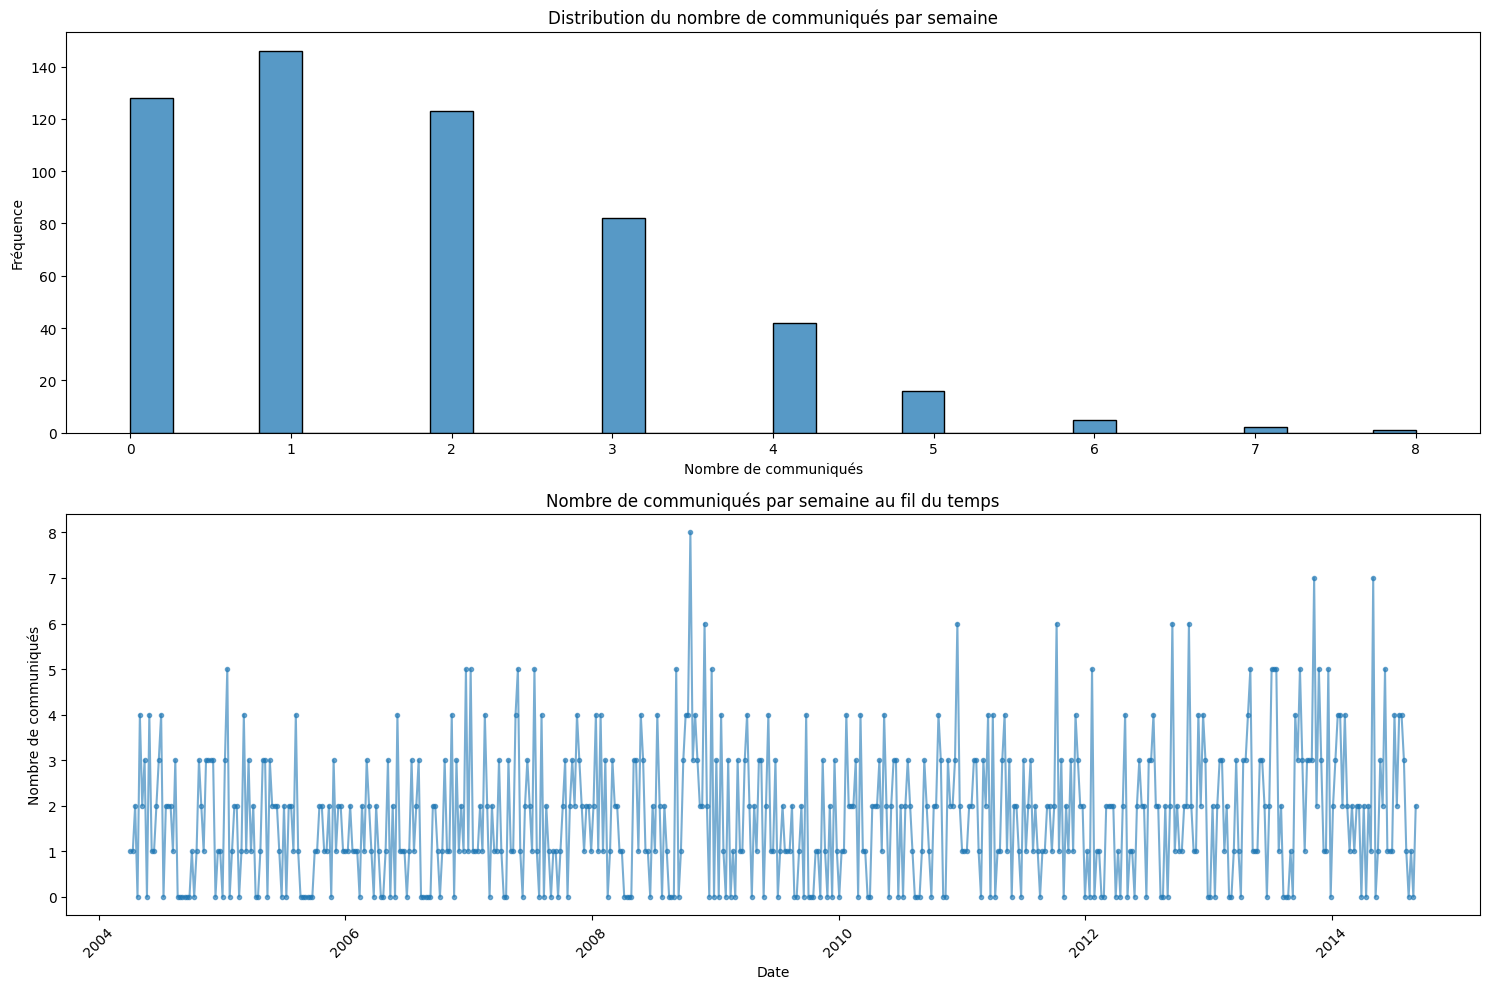


Statistiques descriptives:
count    545.000000
mean       1.721101
std        1.470049
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max        8.000000
Name: len_text_count, dtype: float64


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Créer un DataFrame avec toutes les semaines possibles
start_date = df['Date'].min()
end_date = df['Date'].max()

# Créer une série de dates pour toutes les semaines
all_dates = pd.date_range(start=start_date, end=end_date, freq='W')
all_weeks = pd.DataFrame({
    'Date': all_dates,
    'Year': all_dates.year,
    'Week': all_dates.isocalendar().week,
    'YearWeek': all_dates.strftime('%Y-W%V')
})

# Grouper par mois
df['Date'] = pd.to_datetime(df['Date'])
df['YearWeek'] = df['Date'].dt.strftime('%Y-W%V')

weekly_stats = (
    df.groupby('YearWeek')
      .agg({'len_text': ['count', 'mean'],
            'negativity': 'mean'})
      .reset_index()
)

# Aplatir les colonnes multi-index
weekly_stats.columns = ['YearWeek'] + [
    f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col
    for col in weekly_stats.columns[1:]
]



# Fusionner avec les statistiques existantes
full_stats = all_weeks.merge(
    weekly_stats,
    on='YearWeek',
    how='left'
)




full_stats = full_stats.sort_values('Date')

# Remplacer les NaN par 0 pour le count
full_stats['len_text_count'] = full_stats['len_text_count'].fillna(0)

# Créer une figure avec 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# 1. Histogramme de la distribution
sns.histplot(
    data=full_stats, 
    x='len_text_count',
    bins=30,
    ax=ax1
)
ax1.set_title('Distribution du nombre de communiqués par semaine')
ax1.set_xlabel('Nombre de communiqués')
ax1.set_ylabel('Fréquence')

# 2. Évolution temporelle
ax2.plot(
    full_stats['Date'],
    full_stats['len_text_count'],
    marker='.',
    linestyle='-',
    alpha=0.6
)
ax2.set_title('Nombre de communiqués par semaine au fil du temps')
ax2.set_xlabel('Date')
ax2.set_ylabel('Nombre de communiqués')
ax2.tick_params(axis='x', rotation=45)

# Ajuster la mise en page
plt.tight_layout()
plt.show()

# Afficher quelques statistiques descriptives
print("\nStatistiques descriptives:")
print(full_stats['len_text_count'].describe())

In [11]:
weekly_stats["len_text_count"].sum()

np.int64(2142)

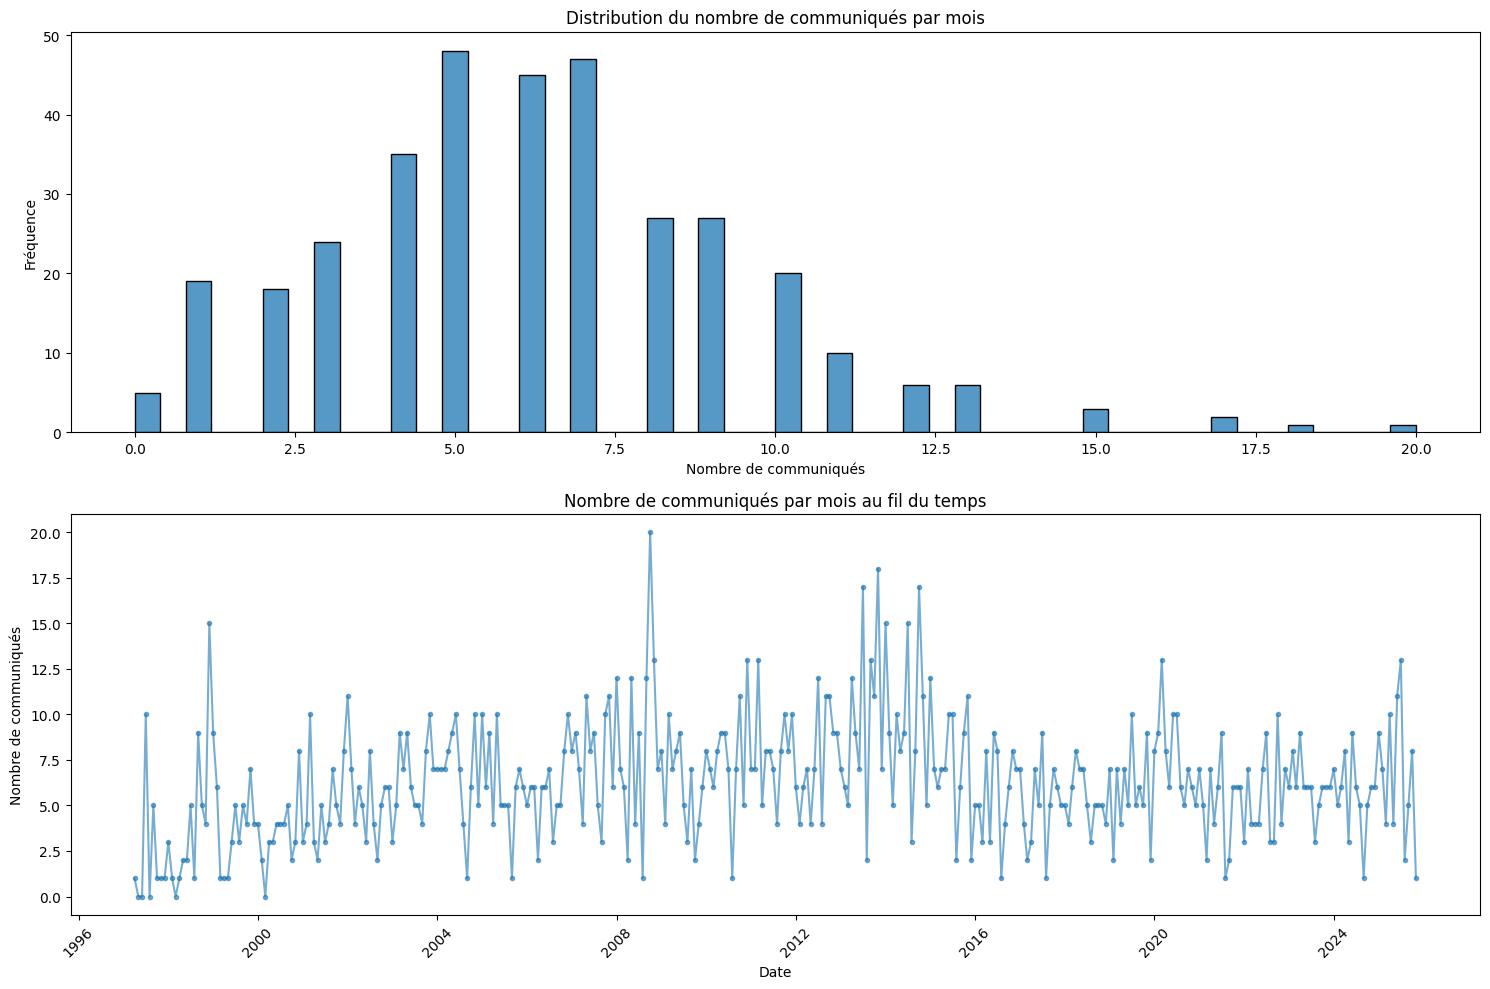


Statistiques descriptives:
count    344.000000
mean       6.226744
std        3.254203
min        0.000000
25%        4.000000
50%        6.000000
75%        8.000000
max       20.000000
Name: len_text_count, dtype: float64


In [12]:
# Convertir la colonne Date en datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')

# Créer une colonne mois (YYYY-MM)
df['YearMonth'] = df['Date'].dt.strftime('%Y-%m')

# Grouper par mois
monthly_stats = df.groupby('YearMonth').agg({
    'len_text': ['count', 'mean'],
    'negativity': 'mean'
}).reset_index()

# Aplatir les colonnes multi-index
monthly_stats.columns = ['YearMonth'] + [
    f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col
    for col in monthly_stats.columns[1:]
]

# Créer un DataFrame avec tous les mois possibles (début de mois)
start_month = df['Date'].min().replace(day=1)
end_month = df['Date'].max().replace(day=1)
all_months = pd.date_range(start=start_month, end=end_month, freq='MS')
all_months_df = pd.DataFrame({
    'Date': all_months,
    'YearMonth': all_months.strftime('%Y-%m')
})

# Fusionner avec les statistiques existantes
full_stats_month = all_months_df.merge(
    monthly_stats,
    on='YearMonth',
    how='left'
)
full_stats_month = full_stats_month.sort_values('Date')

# Remplacer les NaN par 0 pour le count
full_stats_month['len_text_count'] = full_stats_month['len_text_count'].fillna(0)

# Tracés : histogramme + évolution temporelle (mensuelle)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

sns.histplot(
    data=full_stats_month,
    x='len_text_count',
    bins=50,
    ax=ax1
)
ax1.set_title('Distribution du nombre de communiqués par mois')
ax1.set_xlabel('Nombre de communiqués')
ax1.set_ylabel('Fréquence')

ax2.plot(
    full_stats_month['Date'],
    full_stats_month['len_text_count'],
    marker='.',
    linestyle='-',
    alpha=0.6
)
ax2.set_title('Nombre de communiqués par mois au fil du temps')
ax2.set_xlabel('Date')
ax2.set_ylabel('Nombre de communiqués')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print('\nStatistiques descriptives:')
print(full_stats_month['len_text_count'].describe())

In [23]:
dat = yf.Ticker("^STOXX50E")
# dax : ^GDAXI
# CAC 40 : ^FCHI
dat.history(period='max')
dat.history(period='max', interval='1wk')

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2007-03-26 00:00:00+02:00,4177.669922,4207.759766,4160.350098,4181.029785,0,0.0,0.0
2007-04-02 00:00:00+02:00,4177.310059,4274.169922,4163.770020,4271.540039,0,0.0,0.0
2007-04-09 00:00:00+02:00,4275.680176,4326.700195,4249.299805,4317.350098,0,0.0,0.0
2007-04-16 00:00:00+02:00,4333.950195,4431.330078,4288.109863,4416.790039,0,0.0,0.0
2007-04-23 00:00:00+02:00,4416.069824,4434.060059,4348.689941,4383.129883,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-10-13 00:00:00+02:00,5540.540039,5652.109863,5487.669922,5607.390137,99421900,0.0,0.0
2025-10-20 00:00:00+02:00,5626.250000,5699.129883,5626.250000,5674.500000,82756400,0.0,0.0
2025-10-27 00:00:00+01:00,5691.890137,5734.279785,5654.299805,5662.040039,101548400,0.0,0.0


In [30]:
article_list = pd.read_pickle("ecb_press_releases_link_df.pkl")
article_list["file_title"] = article_list.apply(make_safe_title, axis=1)

article_list["random_score"] = np.random.rand(len(article_list))
article_list.head()

weekly_avg = (
    article_list
    .assign(Date_parsed=pd.to_datetime(article_list["Date"], format="%d %B %Y"))
    .groupby(pd.Grouper(key="Date_parsed", freq="W"))
    .agg(
        random_score_mean=("random_score", "mean"),
        article_count=("random_score", "count")
    )
    .reset_index()
)

weekly_avg.head(20)

,Date_parsed,random_score_mean,article_count
0,1997-04-27,0.725961,1
1,1997-05-04,NaN,0
2,1997-05-11,NaN,0
3,1997-05-18,NaN,0
4,1997-05-25,NaN,0
5,1997-06-01,NaN,0
6,1997-06-08,NaN,0
7,1997-06-15,NaN,0
8,1997-06-22,NaN,0
9,1997-06-29,NaN,0


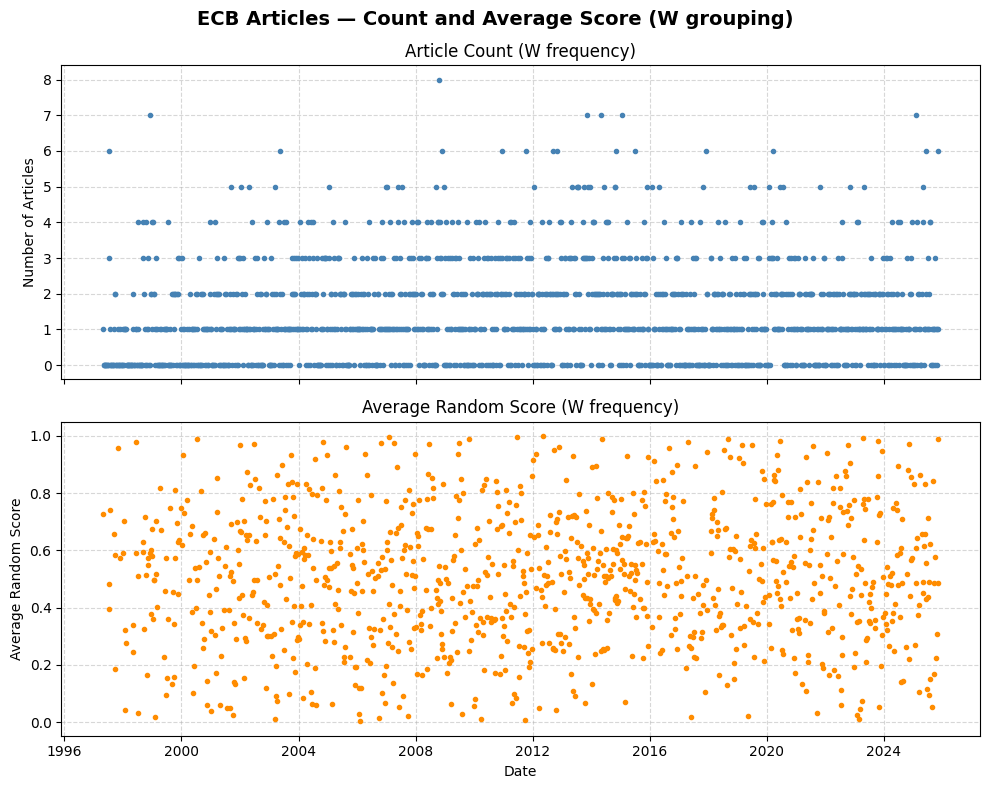

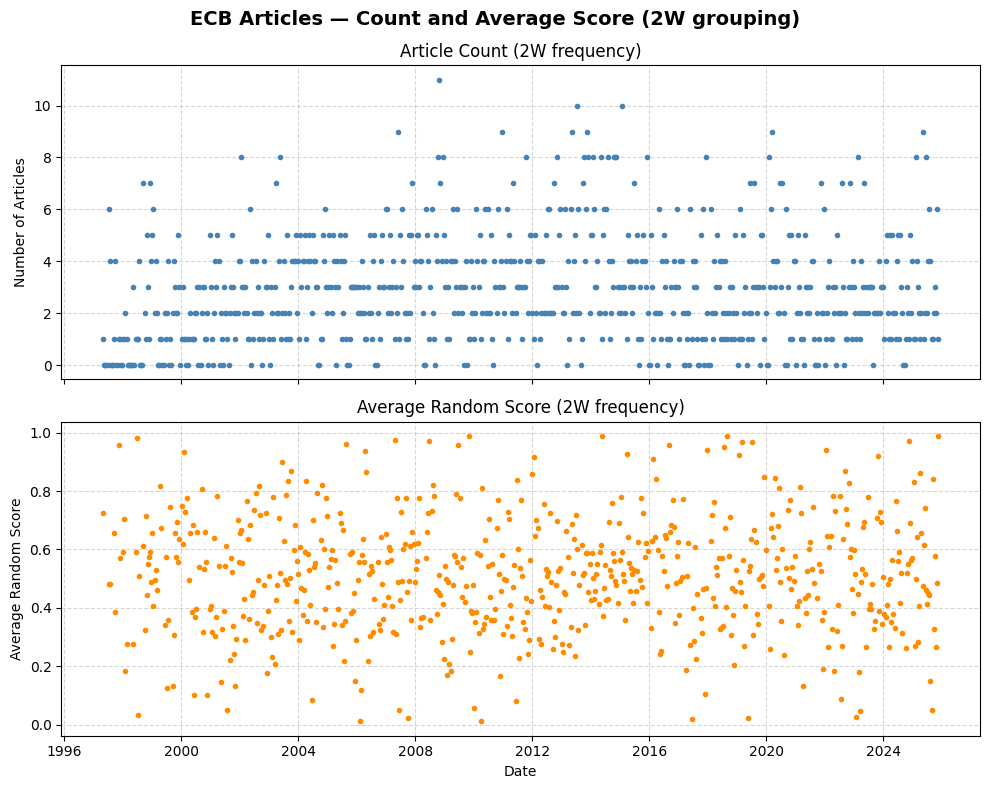

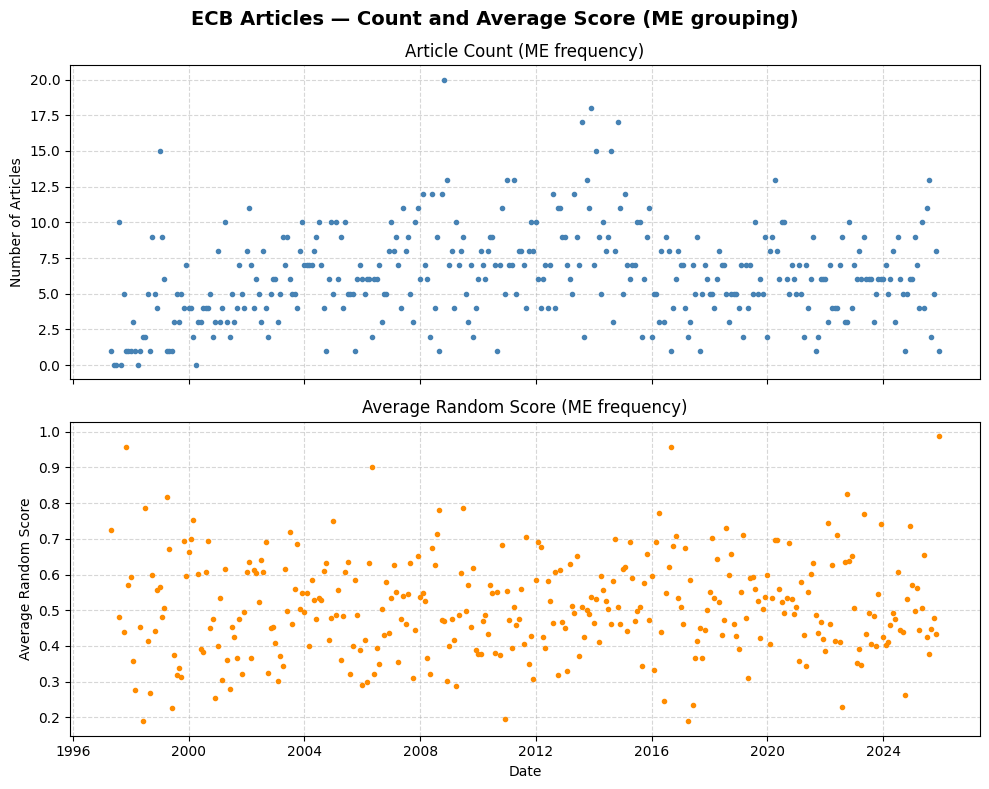

In [39]:
def plot_article_stats(article_df, freq="W"):
    """
    Compute and plot article statistics (count & average random score)
    grouped by a chosen time frequency.
    
    Parameters
    ----------
    article_df : pd.DataFrame
        Must contain columns "Date" (e.g. "5 November 2025") and "random_score".
    freq : str, optional
        Time frequency for grouping.
        Examples:
            'W'  -> weekly (default)
            '2W' -> biweekly
            'M'  -> monthly
    
    Returns
    -------
    weekly_avg : pd.DataFrame
        DataFrame with Date_parsed, average score, and article count.
    fig : matplotlib.figure.Figure
        Figure object with the two subplots.
    """

    # --- Data preparation ---
    df = article_df.copy()
    df["Date_parsed"] = pd.to_datetime(df["Date"], format="%d %B %Y")

    # --- Aggregation ---
    grouped = (
        df.groupby(pd.Grouper(key="Date_parsed", freq=freq))
        .agg(
            random_score_mean=("random_score", "mean"),
            article_count=("random_score", "count")
        )
        .reset_index()
    )

    # --- Plot ---
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot 1: number of articles per period
    ax[0].plot(grouped["Date_parsed"], grouped["article_count"],
               color="steelblue", marker=".", linestyle="")
    ax[0].set_ylabel("Number of Articles")
    ax[0].set_title(f"Article Count ({freq} frequency)")
    ax[0].grid(True, linestyle="--", alpha=0.5)

    # Plot 2: average score per period
    ax[1].plot(grouped["Date_parsed"], grouped["random_score_mean"],
               color="darkorange", marker=".", linestyle="")
    ax[1].set_ylabel("Average Random Score")
    ax[1].set_title(f"Average Random Score ({freq} frequency)")
    ax[1].grid(True, linestyle="--", alpha=0.5)

    # Common labels and layout
    fig.suptitle(f"ECB Articles — Count and Average Score ({freq} grouping)",
                 fontsize=14, fontweight="bold")
    plt.xlabel("Date")
    plt.tight_layout()

    return grouped, fig


weekly_stats_w, fig_weekly_w = plot_article_stats(article_list, freq="W")
weekly_stats_2w, fig_weekly_2w = plot_article_stats(article_list, freq="2W")
weekly_stats_m, fig_weekly_m = plot_article_stats(article_list, freq="ME")

In [41]:
import yfinance as yf
import pandas as pd

def get_aligned_returns(ticker, freq="W", start=None, end=None, ref_df=None):
    """
    Download returns for a given ticker and align them with an existing DataFrame (e.g. weekly_avg).

    Parameters
    ----------
    ticker : str
        Ticker symbol (e.g. '^STOXX50E', '^FCHI', '^GDAXI').
    freq : str, optional
        Frequency for returns: 'W' (weekly), '2W' (biweekly), 'M' (monthly), etc.
        Must match the reference DataFrame grouping frequency.
    start : str or None
        Start date for historical data (e.g. '2010-01-01').
    end : str or None
        End date for historical data (e.g. '2025-11-01').
    ref_df : pd.DataFrame or None
        Reference DataFrame with a datetime column (e.g. 'Date_parsed') to align on.

    Returns
    -------
    returns_df : pd.DataFrame
        DataFrame with columns ['Date', 'Return'] aligned with ref_df (if provided).
    """

    # --- Download data ---
    dat = yf.Ticker(ticker)
    data = dat.history(period="max" if start is None and end is None else None,
                       start=start, end=end)

    if data.empty:
        raise ValueError(f"No data found for ticker {ticker}")

    data = data[["Close"]].copy()
    data.index = pd.to_datetime(data.index)

    # --- Resample to the desired frequency ---
    data_resampled = data.resample(freq).last()

    # --- Compute returns ---
    data_resampled["Return"] = data_resampled["Close"].pct_change()

    # --- Format output ---
    data_resampled = data_resampled.reset_index().rename(columns={"Date": "Date_parsed"})

    # --- Align with reference DataFrame if provided ---
    if ref_df is not None:
        aligned = pd.merge(ref_df, data_resampled[["Date_parsed", "Return"]], on="Date_parsed", how="left")
        return aligned
    else:
        return data_resampled[["Date_parsed", "Return"]]

res = get_aligned_returns("^STOXX50E")

res.head()

,Date_parsed,Return
0,2007-04-01 00:00:00+02:00,NaN
1,2007-04-08 00:00:00+02:00,0.021648
2,2007-04-15 00:00:00+02:00,0.010724
3,2007-04-22 00:00:00+02:00,0.023033
4,2007-04-29 00:00:00+02:00,-0.007621
